In [23]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

from torchvision import transforms
from torch.autograd import Variable

from PIL import Image

In [24]:
net = models.googlenet(pretrained=True)
net.cuda()
net.eval()


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [25]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean=mean, std=std)

mean = torch.tensor(mean)[None,:,None,None]
std  = torch.tensor(std)[None,:,None,None]

def denormalize(x):
    return (std*x + mean)

def jitter(x, pad_width=2, pad_value=1.1):
    N, C, H, W = x.shape
    y = F.pad(x, 4 * (pad_width,), value=pad_value)
    idx, idy = np.random.randint(low=0, high=2*pad_width, size=(2,))
    return y[:, :, idx:idx+H, idy:idy+W]

def color_correction():
    S = np.asarray([[0.26, 0.09, 0.02],
                  [0.27, 0.00, -0.05],
                  [0.27, -0.09, 0.03]]).astype("float32")
    C = S / np.max(np.linalg.norm(S, axis=0))
    C = torch.tensor(C)
    return C.transpose(0,1)

def upsample():
    upsample = torch.nn.Upsample(scale_factor = 0.5, mode='bilinear')
    def up(x):
        upsample.x = (1 + np.random.randn(1)[0]/50, 1 + np.random.randn(1)[0]/50)
        return upsample(x)
    return up

C = color_correction().cuda()

up = upsample()

def preprocess_image(image):
    x0 = (image.reshape(3,224*224).transpose(0,1) @ C).transpose(0,1).reshape(1,3,224,224)
    x1 = torch.sigmoid(x0)
    x2 = normalize(x1[0]).unsqueeze(0)
    x3 = jitter(x2, pad_width=3)
    x4 = up(x3)
    return x4


In [26]:
def create_random_image():
    image = torch.randn([1, 3, 224, 224])/10 + 0.5
    #image = preprocess_image(image.cuda())
    image = image.cuda()
    image.requires_grad = True
    return image

In [27]:
from deep_dream import DeepDream

dd = DeepDream(net)

Loss: 0.7675344347953796
Loss: 10.606963157653809
Loss: 12.178407669067383
Loss: 12.680766105651855
Loss: 13.169206619262695


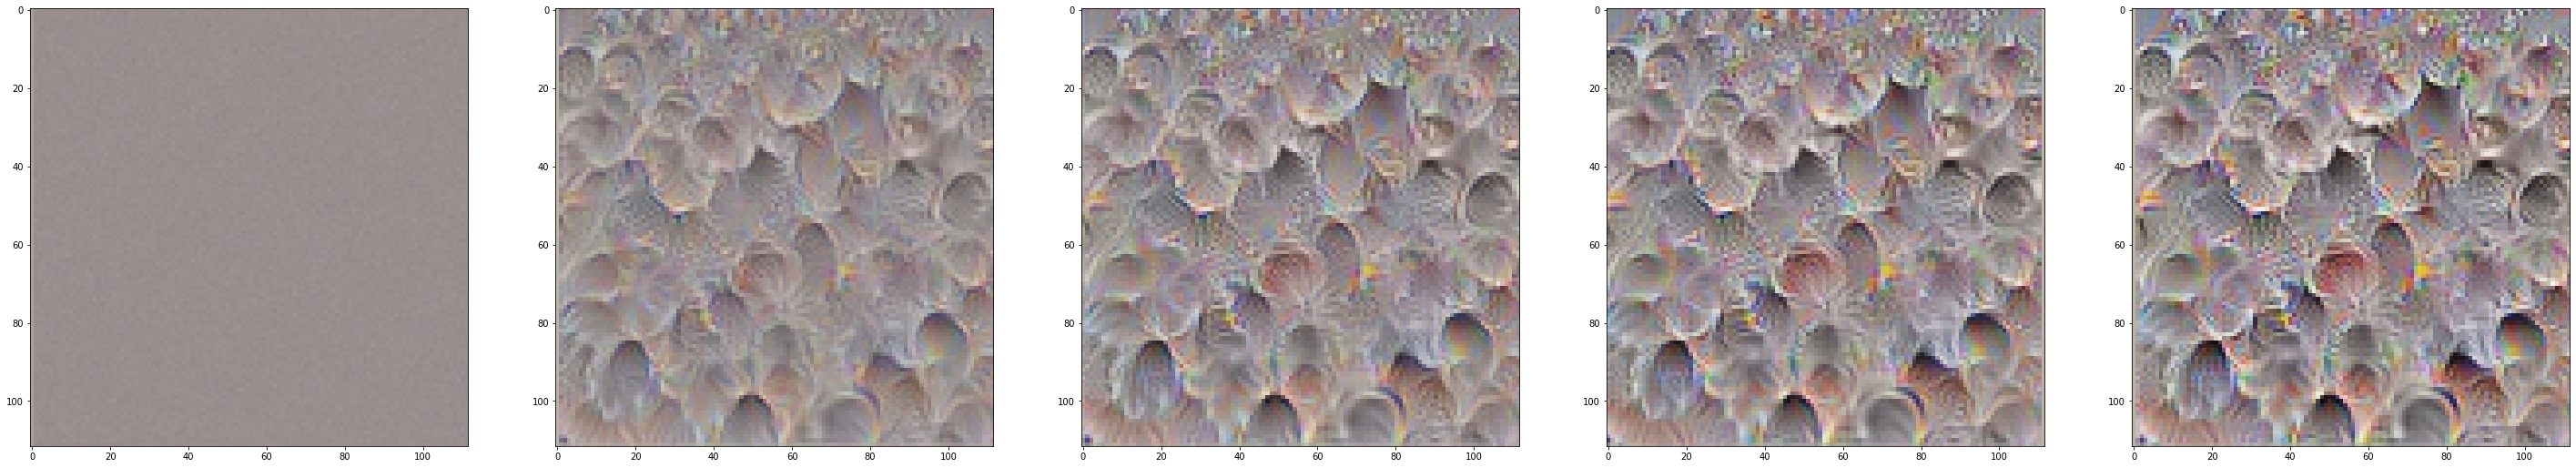

Loss: 0.45508459210395813
Loss: 7.392490386962891
Loss: 8.399311065673828
Loss: 8.849629402160645
Loss: 8.72923469543457


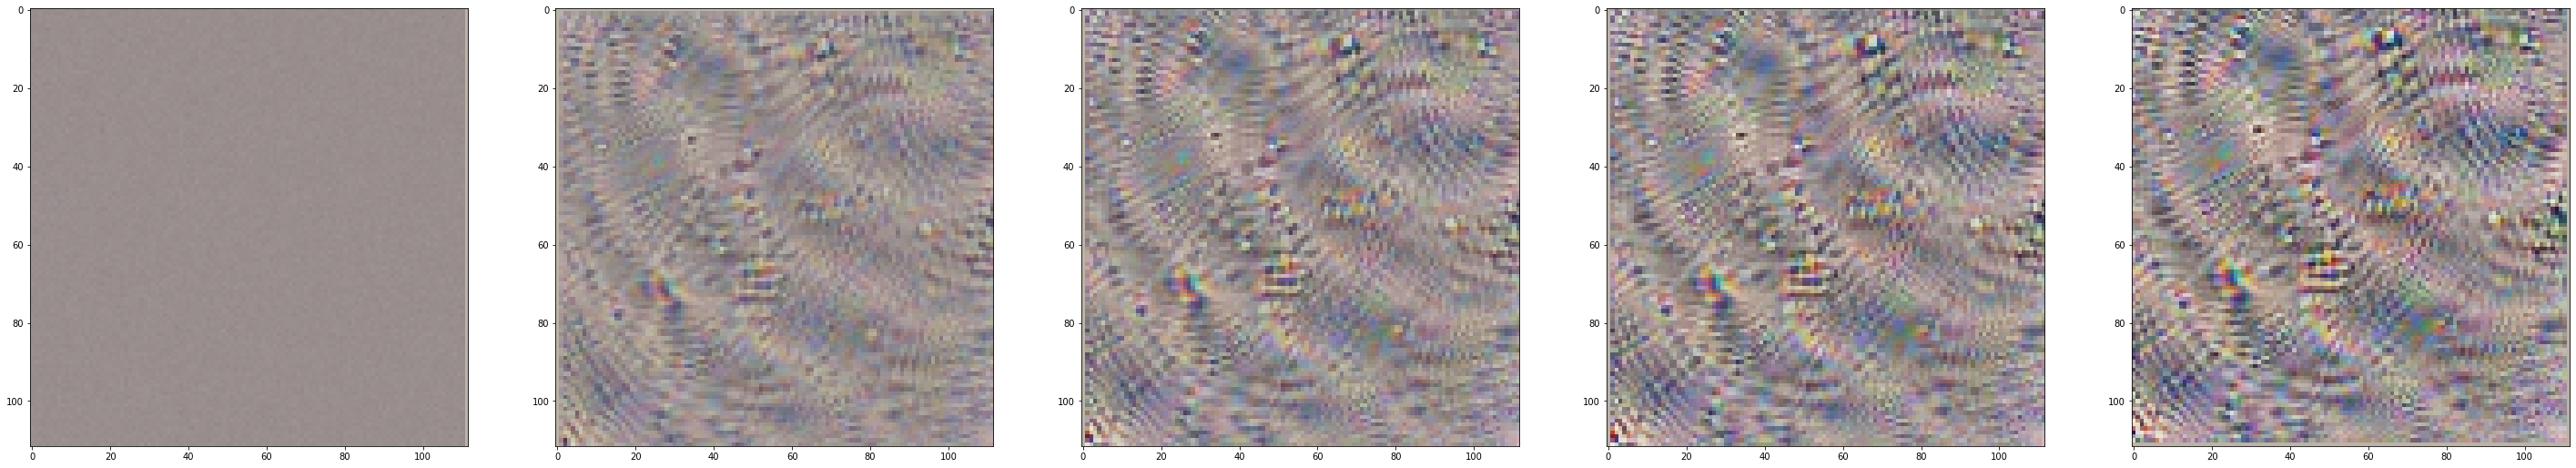

In [28]:
num_iter = 500

#target=(0, 2)
image = create_random_image()
generated_inputs = dd.dream(image, optimizer=optim.Adam, optimizer_params={'lr': 0.05}, num_iter=num_iter, target=(0, 2), layer=net.inception4c, transform=preprocess_image, lag=100, return_generated_inputs=True, verbose=True)
f,ax = plt.subplots(1,num_iter // 100, figsize=(50,100))
for i, generated_input in enumerate(generated_inputs):
    ax[i].imshow((denormalize(generated_input.cpu()).detach().numpy()[0].transpose(1,2,0)* 255).astype(np.uint8))
plt.show()

image = create_random_image()
generated_inputs = dd.dream(image, optimizer=optim.Adam, optimizer_params={'lr': 0.05}, num_iter=num_iter, target=(0, 1), layer=net.inception4c, transform=preprocess_image, lag=100, return_generated_inputs=True, verbose=True)
f,ax = plt.subplots(1,num_iter // 100, figsize=(50,100))
for i, generated_input in enumerate(generated_inputs):
    ax[i].imshow((denormalize(generated_input.cpu()).detach().numpy()[0].transpose(1,2,0)* 255).astype(np.uint8))
plt.show()   


cuda:0
Loss: 0.08544126898050308
Loss: 20.382015228271484
Loss: 23.307294845581055
Loss: 24.80390167236328
Loss: 26.04254722595215


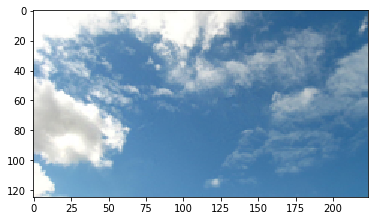

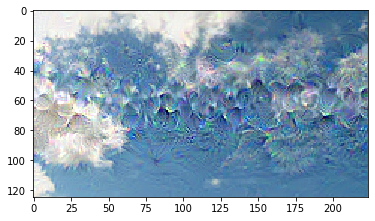

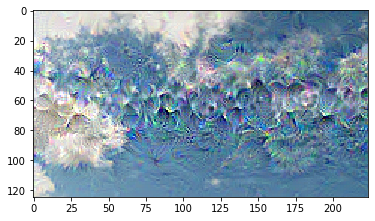

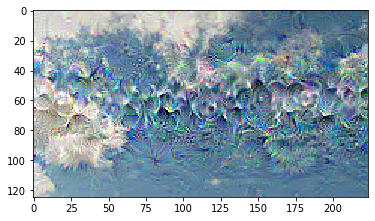

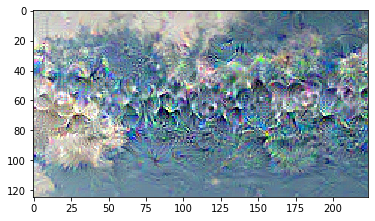

In [29]:
import copy 
def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((224, 224))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    #im_as_var = Variable(im_as_ten)
    return im_as_ten


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

im_path = 'img/sky-dd.jpeg'
created_image = Image.open(im_path).convert('RGB')
processed_image = preprocess_image(created_image, True)
processed_image = processed_image.cuda()
processed_image.requires_grad_(True)
print(processed_image.device)
outputs = dd.dream(processed_image, target=(0, 2, 3), layer=net.inception4c, optimizer_params={'lr': 12, 'weight_decay':1e-4})

for i, output in enumerate(outputs):
        created_image = recreate_image(output.cpu().detach())
        plt.imshow(created_image)
        plt.show()